In [137]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import scikitplot as skplt
from scikitplot.estimators import plot_learning_curve
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import glob

from skimage import color, exposure
from sklearn.metrics import classification_report


from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform

from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import re
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('./Dane/df_bezNan.csv',index_col='Unnamed: 0')

In [15]:
# del df['Liczba bledow']

In [16]:
df

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-1,16.2","fBodyAcc-bandsEnergy()-1,24","fBodyAcc-bandsEnergy()-1,24.1","fBodyAcc-bandsEnergy()-1,24.2","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8.1","fBodyAcc-bandsEnergy()-1,8.2","fBodyAcc-bandsEnergy()-17,24","fBodyAcc-bandsEnergy()-17,24.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-17,32","fBodyAcc-bandsEnergy()-17,32.1","fBodyAcc-bandsEnergy()-17,32.2","fBodyAcc-bandsEnergy()-25,32","fBodyAcc-bandsEnergy()-25,32.1","fBodyAcc-bandsEnergy()-25,32.2","fBodyAcc-bandsEnergy()-25,48","fBodyAcc-bandsEnergy()-25,48.1","fBodyAcc-bandsEnergy()-25,48.2","fBodyAcc-bandsEnergy()-33,40","fBodyAcc-bandsEnergy()-33,40.1","fBodyAcc-bandsEnergy()-33,40.2","fBodyAcc-bandsEnergy()-33,48","fBodyAcc-bandsEnergy()-33,48.1","fBodyAcc-bandsEnergy()-33,48.2","fBodyAcc-bandsEnergy()-41,48","fBodyAcc-bandsEnergy()-41,48.1","fBodyAcc-bandsEnergy()-41,48.2","fBodyAcc-bandsEnergy()-49,56","fBodyAcc-bandsEnergy()-49,56.1","fBodyAcc-bandsEnergy()-49,56.2","fBodyAcc-bandsEnergy()-49,64","fBodyAcc-bandsEnergy()-49,64.1","fBodyAcc-bandsEnergy()-49,64.2","fBodyAcc-bandsEnergy()-57,64","fBodyAcc-bandsEnergy()-57,64.1","fBodyAcc-bandsEnergy()-57,64.2","fBodyAcc-bandsEnergy()-9,16","fBodyAcc-bandsEnergy()-9,16.1","fBodyAcc-bandsEnergy()-9,16.2",fBodyAcc-energy()-X,fBodyAcc-energy()-Y,fBodyAcc-energy()-Z,fBodyAcc-entropy()-X,fBodyAcc-entropy()-Y,fBodyAcc-entropy()-Z,fBodyAcc-iqr()-X,fBodyAcc-iqr()-Y,fBodyAcc-iqr()-Z,fBodyAcc-kurtosis()-X,fBodyAcc-kurtosis()-Y,fBodyAcc-kurtosis()-Z,fBodyAcc-mad()-X,fBodyAcc-mad()-Y,fBodyAcc-mad()-Z,fBodyAcc-main()-X,fBodyAcc-main()-Y,fBodyAcc-main()-Z,fBodyAcc-max()-X,fBodyAcc-max()-Y,fBodyAcc-max()-Z,fBodyAcc-maxInds-X,fBodyAcc-maxInds-Y,fBodyAcc-maxInds-Z,fBodyAcc-mean()-X,fBodyAcc-mean()-Y,fBodyAcc-mean()-Z,fBodyAcc-meanFreq()-X,fBodyAcc-meanFreq()-Y,fBodyAcc-meanFreq()-Z,fBodyAcc-min()-X,fBodyAcc-min()-Y,fBodyAcc-min()-Z,fBodyAcc-skewness()-X,fBodyAcc-skewness()-Y,fBodyAcc-skewness()-Z,fBodyAcc-sma(),fBodyAcc-std()-X,fBodyAcc-std()-Y,fBodyAcc-std()-Z,"fBodyAccJerk-bandsEnergy()-1,16","fBodyAccJerk-bandsEnergy()-1,16.1","fBodyAccJerk-bandsEnergy()-1,16.2","fBodyAccJerk-bandsEnergy()-1,24","fBodyAccJerk-bandsEnergy()-1,24.1","fBodyAccJerk-bandsEnergy()-1,24.2","fBodyAccJerk-bandsEnergy()-1,8","fBodyAccJerk-bandsEnergy()-1,8.1","fBodyAccJerk-bandsEnergy()-1,8.2","fBodyAccJerk-bandsEnergy()-17,24","fBodyAccJerk-bandsEnergy()-17,24.1","fBodyAccJerk-bandsEnergy()-17,24.2","fBodyAccJerk-bandsEnergy()-17,32","fBodyAccJerk-bandsEnergy()-17,32.1","fBodyAccJerk-bandsEnergy()-17,32.2","fBodyAccJerk-bandsEnergy()-25,32","fBodyAccJerk-bandsEnergy()-25,32.1","fBodyAccJerk-bandsEnergy()-25,32.2","fBodyAccJerk-bandsEnergy()-25,48","fBodyAccJerk-bandsEnergy()-25,48.1","fBodyAccJerk-bandsEnergy()-25,48.2","fBodyAccJerk-bandsEnergy()-33,40","fBodyAccJerk-bandsEnergy()-33,40.1","fBodyAccJerk-bandsEnergy()-33,40.2","fBodyAccJerk-bandsEnergy()-33,48","fBodyAccJerk-bandsEnergy()-33,48.1","fBodyAccJerk-bandsEnergy()-33,48.2","fBodyAccJerk-bandsEnergy()-41,48","fBodyAccJerk-bandsEnergy()-41,48.1","fBodyAccJerk-bandsEnergy()-41,48.2","fBodyAccJerk-bandsEnergy()-49,56","fBodyAccJerk-bandsEnergy()-49,56.1","fBodyAccJerk-bandsEnergy()-49,56.2","fBodyAccJerk-bandsEnergy()-49,64","fBodyAccJerk-bandsEnergy()-49,64.1","fBodyAccJerk-bandsEnergy()-49,64.2","fBodyAccJerk-bandsEnergy()-57,64","fBodyAccJerk-bandsEnergy()-57,64.1","fBodyAccJerk-bandsEnergy()-57,64.2","fBodyAccJerk-bandsEnergy()-9,16","fBodyAccJerk-bandsEnergy()-9,16.1","fBodyAccJerk-bandsEnergy()-9,16.2",fBodyAccJerk-energy()-X,fBodyAccJerk-energy()-Y,fBodyAccJerk-energy()-Z,fBodyAccJerk-entropy()-X,fBodyAccJerk-entropy()-Y,fBodyAccJerk-entropy()-Z,fBodyAc

In [135]:
metrics = {
    'accuracy': accuracy_score,
    'recall': recall_score,
    'precision': precision_score,
    'f1_score': f1_score,
    'roc_auc': roc_auc_score,
}

models = {
    'LGR': LogisticRegression(solver = 'lbfgs', random_state=42, verbose=0),
    'DTC': DecisionTreeClassifier(random_state=42),
    'RFC': RandomForestClassifier(random_state=42),
    'ETC': ExtraTreesClassifier(random_state=42),
    'XGB': xgb.XGBClassifier(random_state=42),
    'LGBM': lgb.LGBMClassifier(random_state=42),
    'CTB': ctb.CatBoostClassifier(verbose=0),
}

In [12]:
def train_model(model, X, y):
    model.fit(X, y)
    return model

In [13]:
def predict_model(model, X):
    y_pred = model.predict(X)
    return y_pred

In [207]:
def score_model(y_test, y_pred, scoring):
    score = scoring(y_test, y_pred, average='micro')
    return score

In [64]:
def train_and_predict(model, X, y, scoring):
    scores = cross_val_score(model, X, y, cv = 3, scoring = scoring)
    return np.mean(scores), np.std(scores)

In [184]:
def split_data(df):
    feats = [feat for feat in df.columns if feat != 'Activity']
    
    X = df[feats]
    y = df['Activity']
    
    return X, y

In [196]:
df1 = df
df1 = df1.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [132]:
def run_model(model, df, scoring):
    
    X, y = split_data(df)
    y = y.factorize()[0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred,average='micro')
    precision = precision_score(y_test, y_pred,average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1_micro: ', f1)
    print(classification_report(y_test, y_pred))
    
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues');    
    plt.show()
    plot_learning_curve(model, X_test, y_test, scoring='f1_micro');    
    plt.show()

In [205]:
for model in models.items():
    print(model[0])
    run_model(model[1], df1, metrics['f1_score'])

In [197]:
X, y = split_data(df1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [198]:
model = models['XGB']

In [199]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [200]:
imp = PermutationImportance(model, random_state = 2021).fit(X_train, y_train)
eli5.show_weights(imp, feature_names = X_train.columns.values, top = 50)

Weight,Feature
0.2522 ± 0.0022,angleXgravityMean
0.0008 ± 0.0003,fBodyGyromaxIndsZ
0.0007 ± 0.0007,tBodyGyromaxX
0.0006 ± 0.0002,angleYgravityMean
0.0005 ± 0.0002,fBodyAccbandsEnergy18
0.0003 ± 0.0003,tBodyAcccorrelationXY
0.0001 ± 0.0000,fBodyAccMagstd
0.0001 ± 0.0000,fBodyGyromaxIndsX
0.0001 ± 0.0001,tBodyAccentropyX
0.0001 ± 0.0001,tGravityAccarCoeffX1


In [201]:
small_feats = [
    'angleXgravityMean',
    'fBodyGyromaxIndsZ',
    'tBodyGyromaxX',
    'angleYgravityMean',
    'fBodyAccbandsEnergy18',
    'tBodyAcccorrelationXY',
    'fBodyAccMagstd',
    'fBodyGyromaxIndsX',
    'tBodyAccentropyX',
    'tGravityAccarCoeffX1',
    'fBodyAccmaxX',
    'tGravityAccmaxY',
    'tGravityAccminY',
]

In [202]:
def split_data_sm(df):
    X = df[small_feats]
    y = df['Activity']
    print(X)
    return X, y

In [203]:
def run_model_sm(model, df, scoring):
    
    X, y = split_data_sm(df)
    y = y.factorize()[0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred,average='micro')
    precision = precision_score(y_test, y_pred,average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1_micro: ', f1)
    print(classification_report(y_test, y_pred))
    
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues');    
    plt.show()
    plot_learning_curve(model, X_test, y_test, scoring='f1_micro');    
    plt.show()

LGR
       angleXgravityMean  fBodyGyromaxIndsZ  tBodyGyromaxX  angleYgravityMean  \
0              -1.574191           1.106818       1.141714          -0.805700   
1              -1.568669           1.106818      -0.220436          -0.612620   
2              -1.548333           0.544982       1.783924          -0.139628   
3              -1.574094           0.966359       0.289834          -0.793443   
5              -1.575809           1.247276       2.190789          -0.640702   
...                  ...                ...            ...                ...   
11080          -1.575492           0.685441      -1.095905          -0.614487   
11081          -1.568669           1.106818      -0.220436          -0.612620   
11082          -1.550288           0.966359       1.180480          -0.231565   
11083          -1.569815           1.106818      -0.938951          -0.794940   
11085          -1.573186           0.404524       0.689142          -0.584008   

       fBodyAccbandsEne

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[0 0 5 ... 2 4 1] 

accuracy:  0.8747844084166954
recall:  0.8747844084166954
precision:  0.8747844084166954
f1_micro:  0.8747844084166954
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       553
           1       0.84      0.88      0.86       395
           2       0.92      0.90      0.91       539
           3       0.94      0.91      0.93       492
           4       0.81      0.79      0.80       540
           5       0.89      0.89      0.89       380

    accuracy                           0.87      2899
   macro avg       0.88      0.88      0.88      2899
weighted avg       0.88      0.87      0.87      2899



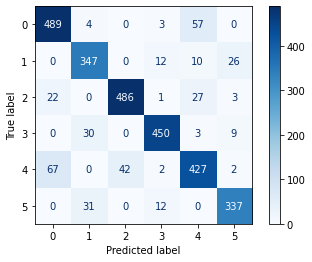

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    

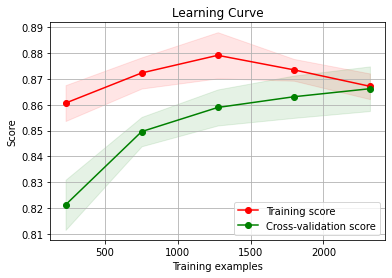

DTC
       angleXgravityMean  fBodyGyromaxIndsZ  tBodyGyromaxX  angleYgravityMean  \
0              -1.574191           1.106818       1.141714          -0.805700   
1              -1.568669           1.106818      -0.220436          -0.612620   
2              -1.548333           0.544982       1.783924          -0.139628   
3              -1.574094           0.966359       0.289834          -0.793443   
5              -1.575809           1.247276       2.190789          -0.640702   
...                  ...                ...            ...                ...   
11080          -1.575492           0.685441      -1.095905          -0.614487   
11081          -1.568669           1.106818      -0.220436          -0.612620   
11082          -1.550288           0.966359       1.180480          -0.231565   
11083          -1.569815           1.106818      -0.938951          -0.794940   
11085          -1.573186           0.404524       0.689142          -0.584008   

       fBodyAccbandsEne

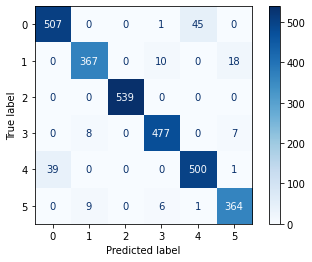

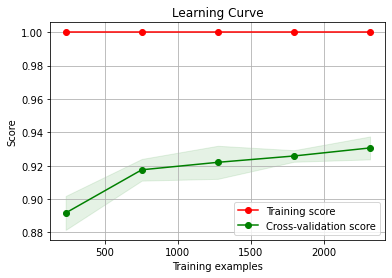

RFC
       angleXgravityMean  fBodyGyromaxIndsZ  tBodyGyromaxX  angleYgravityMean  \
0              -1.574191           1.106818       1.141714          -0.805700   
1              -1.568669           1.106818      -0.220436          -0.612620   
2              -1.548333           0.544982       1.783924          -0.139628   
3              -1.574094           0.966359       0.289834          -0.793443   
5              -1.575809           1.247276       2.190789          -0.640702   
...                  ...                ...            ...                ...   
11080          -1.575492           0.685441      -1.095905          -0.614487   
11081          -1.568669           1.106818      -0.220436          -0.612620   
11082          -1.550288           0.966359       1.180480          -0.231565   
11083          -1.569815           1.106818      -0.938951          -0.794940   
11085          -1.573186           0.404524       0.689142          -0.584008   

       fBodyAccbandsEne

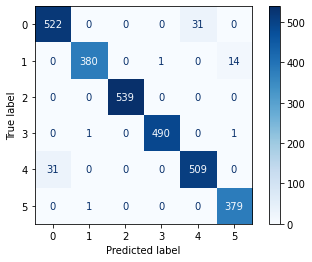

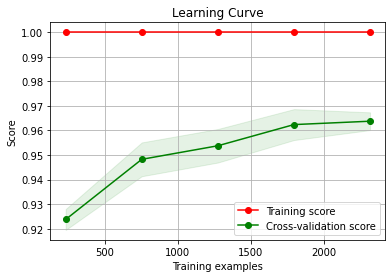

ETC
       angleXgravityMean  fBodyGyromaxIndsZ  tBodyGyromaxX  angleYgravityMean  \
0              -1.574191           1.106818       1.141714          -0.805700   
1              -1.568669           1.106818      -0.220436          -0.612620   
2              -1.548333           0.544982       1.783924          -0.139628   
3              -1.574094           0.966359       0.289834          -0.793443   
5              -1.575809           1.247276       2.190789          -0.640702   
...                  ...                ...            ...                ...   
11080          -1.575492           0.685441      -1.095905          -0.614487   
11081          -1.568669           1.106818      -0.220436          -0.612620   
11082          -1.550288           0.966359       1.180480          -0.231565   
11083          -1.569815           1.106818      -0.938951          -0.794940   
11085          -1.573186           0.404524       0.689142          -0.584008   

       fBodyAccbandsEne

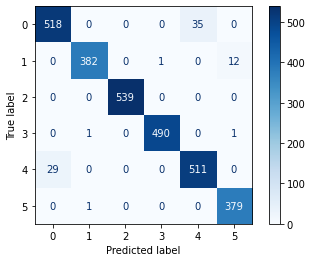

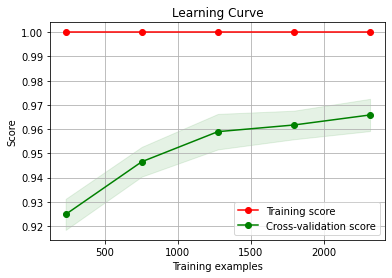

XGB
       angleXgravityMean  fBodyGyromaxIndsZ  tBodyGyromaxX  angleYgravityMean  \
0              -1.574191           1.106818       1.141714          -0.805700   
1              -1.568669           1.106818      -0.220436          -0.612620   
2              -1.548333           0.544982       1.783924          -0.139628   
3              -1.574094           0.966359       0.289834          -0.793443   
5              -1.575809           1.247276       2.190789          -0.640702   
...                  ...                ...            ...                ...   
11080          -1.575492           0.685441      -1.095905          -0.614487   
11081          -1.568669           1.106818      -0.220436          -0.612620   
11082          -1.550288           0.966359       1.180480          -0.231565   
11083          -1.569815           1.106818      -0.938951          -0.794940   
11085          -1.573186           0.404524       0.689142          -0.584008   

       fBodyAccbandsEne

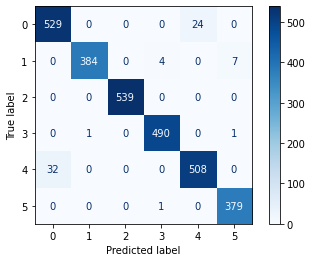

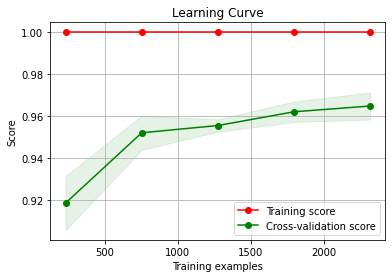

LGBM
       angleXgravityMean  fBodyGyromaxIndsZ  tBodyGyromaxX  angleYgravityMean  \
0              -1.574191           1.106818       1.141714          -0.805700   
1              -1.568669           1.106818      -0.220436          -0.612620   
2              -1.548333           0.544982       1.783924          -0.139628   
3              -1.574094           0.966359       0.289834          -0.793443   
5              -1.575809           1.247276       2.190789          -0.640702   
...                  ...                ...            ...                ...   
11080          -1.575492           0.685441      -1.095905          -0.614487   
11081          -1.568669           1.106818      -0.220436          -0.612620   
11082          -1.550288           0.966359       1.180480          -0.231565   
11083          -1.569815           1.106818      -0.938951          -0.794940   
11085          -1.573186           0.404524       0.689142          -0.584008   

       fBodyAccbandsEn

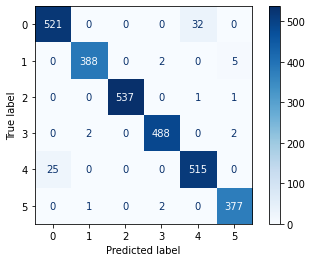

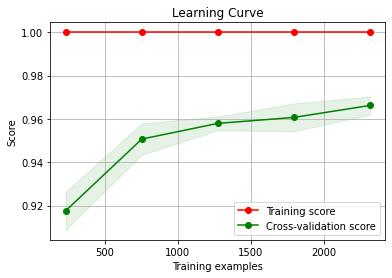

CTB
       angleXgravityMean  fBodyGyromaxIndsZ  tBodyGyromaxX  angleYgravityMean  \
0              -1.574191           1.106818       1.141714          -0.805700   
1              -1.568669           1.106818      -0.220436          -0.612620   
2              -1.548333           0.544982       1.783924          -0.139628   
3              -1.574094           0.966359       0.289834          -0.793443   
5              -1.575809           1.247276       2.190789          -0.640702   
...                  ...                ...            ...                ...   
11080          -1.575492           0.685441      -1.095905          -0.614487   
11081          -1.568669           1.106818      -0.220436          -0.612620   
11082          -1.550288           0.966359       1.180480          -0.231565   
11083          -1.569815           1.106818      -0.938951          -0.794940   
11085          -1.573186           0.404524       0.689142          -0.584008   

       fBodyAccbandsEne

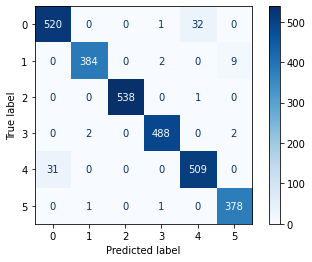

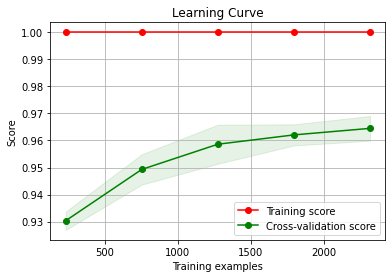

In [204]:
for model in models.items():
    print(model[0])
    run_model_sm(model[1], df1, metrics['f1_score'])

In [212]:
def hyperopt():
    trials = Trials()
    
    space ={
        'max_depth': hp.quniform ('depth', 2, 8, 1),
        'learning_rate': hp.uniform ('learning_rate', 0.01, 0.5),
        'subsample': hp.uniform ('subsample', 0.8, 1.),
        'reg_lambda': hp.uniform ('reg_lambda', 0.7, 1.),
        'n_estimators': hp.quniform ('n_estimators', 10, 600, 1),
        'random_state': 42,
    }
    
    best_params = fmin(fn=objective,
                space=space,
                algo=partial(tpe.suggest, n_startup_jobs=1),
                max_evals=60,
                trials=trials)

    print("The best params: ", best_params)
    return trials.best_trial

def objective(space):
    
    params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': int(space['n_estimators']),
        'random_state': int(space['random_state']),
    }
    
    model = xgb.XGBClassifier(**params)
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    score = score_model(y_test, y_pred, f1_score)
    
    return{'loss': -score, 'status': STATUS_OK }

In [213]:
hyperopt()

  3%|▎         | 2/60 [01:05<31:41, 32.78s/trial, best loss: -0.9906864436012418]


KeyboardInterrupt: 